In [106]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from gridworld.environment import WindyGridworld
from tensorflow import keras
from tqdm.notebook import tqdm
import pandas as pd
import copy


## Learning $\pi_b$ from $\mathcal{D} = \{s,a,s',r\}$

In [110]:
def load_dataset_and_trajectories(filename):
    npz = np.load(filename, allow_pickle=True)
    print(npz.files)
    return npz['centroids'], npz['clusters'], npz['trajectories'], npz['rewards'], npz['unique_concepts'], npz['concepts'], npz['actions']

means, clusters, trajectories, rewards, unique_concepts, concepts, actions = load_dataset_and_trajectories("saved_data/dataset_epsilon_large.npz") #We're using dataset_large and dataset_knn
print(trajectories.shape)
print(rewards.shape)
print(unique_concepts.shape)
print(concepts.shape)
print(actions.shape)
print(means.shape)
print(clusters.shape)

from sklearn.neighbors import KNeighborsClassifier
import numpy as np

num_concepts = len(means)
examples_per_concept = int(len(clusters)/num_concepts)
print(examples_per_concept)
# Load some example data
X_train = np.array(clusters)
y_train = np.repeat(np.linspace(0, num_concepts, num_concepts, endpoint=False), examples_per_concept)
X_test = np.array([[1,1], [3,3],[0,-2]])


# Create a kNN classifier with k=3
knn = KNeighborsClassifier(n_neighbors=10) #smaller k values results in more fluctuation of the concepts

# Train the classifier
knn.fit(X_train, y_train)


env = WindyGridworld(num_concepts=num_concepts, method="knn", knn=knn, means=means, policy_model=None, custom_policy=None)

['centroids', 'clusters', 'trajectories', 'rewards', 'unique_concepts', 'concepts', 'actions']
(7000,)
(7000,)
(7000,)
(7000,)
(7000,)
(5, 2)
(500, 2)
100


# Data pre-processing

In [3]:
A = env.A

def generate_default_dataset(window_size, concept_mapping=None, concept_path=None):
    actions_indexed = actions_to_action_indexes(np.concatenate(actions))
    Y = actions_indexed.reshape(len(actions_indexed), 1)
    # Y = np.concatenate(actions)
    X = np.concatenate(window_states(trajectories, W_s=window_size))
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    return X_train, X_test, to_categorical(y_train, 4), to_categorical(y_test, 4)

def window_states(trajectories, W_s=30):
    '''Replaces each state with the average value of previous W_s states including the current state, smoothing the trajectories.'''
    windowed_trajectories = []
    for traj in trajectories:
        windowed_traj = np.zeros((len(traj), 2))
        for i in range(1, len(traj)+1):
            window = traj[i - min(W_s, i):i]
            windowed_traj[i-1] = np.sum(window, axis=0)/len(window)
        windowed_trajectories.append(windowed_traj)
    return np.array(windowed_trajectories, dtype='object')

def actions_to_action_indexes(actions):
    '''Returns the index of the action in the state space, e.g. 0 for up, 1 for right etc'''
    indicies = [np.where(np.all((A == a), axis=1))[0][0] for a in actions]
    return np.array(indicies)

## Learning $\pi_b$

### $\pi_b(a|\hat{s})$
Here $\hat{s}$ is the average state over a window of previous states of length $W_s$.
For use in vanilla IS.

In [111]:
# from models.policy import PolicyModel

# X_train, X_test, y_train, y_test = generate_default_dataset(window_size=5)
# print(X_train.shape)
# print(y_train.shape)
# pi_b = PolicyModel(input_size=X_train[0].shape, num_actions=4).build()
# history = pi_b.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose = 1)
# pi_b.save("saved_models/pi_b_new")
pi_b = keras.models.load_model("saved_models/pi_b") 

In [112]:
pi_b.predict(np.array([-6,-2]).reshape(1,2))[0]

array([0.63559353, 0.06822748, 0.22557862, 0.07060035], dtype=float32)

In [ ]:
fig, ax2 = plt.subplots(figsize=(16,8))

env.policy_model = pi_b #set policy of agent in the environment

for y in np.linspace(-3,2,2):
    print(y)
    history = env.play(True, [], [], [], [], [], s = np.array([-3, y]))
    print(len(history))
    plt.plot(history[:, 0], history[:, 1])

rect = patches.Rectangle([3, 3], 1, 1, fill=True, color="grey", alpha=0.5)
ax2.add_patch(rect)

for i in range(num_concepts):
    start = i*100
    end = (i+1)*100
    plt.scatter(clusters[start:end,0], clusters[start:end,1], label=f"Cluster {i}")

plt.legend()
plt.title("Trajectory through Windy Gridworld")
plt.show()

### $\pi_b(a|c=f(\hat{s}))$
For use in concept IS. Can also just use default policy used to generate data, inherent to the dataset $\mathcal{D}$, but would like to try both.

In [113]:
# from models.policy import PolicyModel

# X_train, X_test, y_train, y_test = generate_default_dataset(window_size=5)
# #conver to concepts here
# concept_model = keras.models.load_model("saved_models/c_new|s")
# Xc_train = concept_model.predict(X_train)
# Xc_test = concept_model.predict(X_test)
# pi_b_c = PolicyModel(input_size=Xc_train[0].shape, num_actions=4).build()
# history = pi_b_c.fit(Xc_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose = 1)
# pi_b_c.save("saved_models/pi_b_c_new")
concept_model = keras.models.load_model("saved_models/c|s")
pi_b_c = keras.models.load_model("saved_models/pi_b_c")                                                                                                                                                      

In [129]:
input = [0, 0, 1, 0, 0]
input2 = concept_model.predict(np.array([-2,-2]).reshape(1,2))[0]
print(pi_b.predict(np.array([-1,-1]).reshape(1,2)))
print(input)
print(input2)
index = np.argmax(input2)

input2 = (np.where(input2 == np.max(input2),1,0))
print(input2)
print("concept: ", np.argmax(input2))
print(pi_b_c.predict(np.array(input).reshape(1,len(input)))) #action probability distribution for a given concept
print(pi_b_c.predict(np.array(input2).reshape(1,len(input))))
# np.mean(pi_b_c.predict(Xc_test), axis=0) #[0.45344904 0.09541331 0.35941267 0.09172497] on new dataset, [0.55403537 0.07854813 0.28875828 0.07865817] under original pi_b_c

[[0.5614386  0.07768164 0.28785586 0.07302386]]
[0, 0, 1, 0, 0]
[0.0000000e+00 0.0000000e+00 9.9991083e-01 0.0000000e+00 8.9165063e-05]
[0 0 1 0 0]
concept:  2
[[0.438365   0.11837474 0.3666041  0.07665614]]
[[0.438365   0.11837474 0.3666041  0.07665614]]


In [ ]:
d0 = np.array([0.4281377,  0.07250687, 0.42525867, 0.07409684])
d1 = np.array([0.20833136, 0.20546675, 0.51395243, 0.07224946])
d2 = np.array([0.438365 ,  0.11837474, 0.3666041 , 0.07665614])
d3 = np.array([0.30413994, 0.17288451, 0.4509015,  0.07207396])
d4 = np.array([0.55403537, 0.07854813, 0.28875828, 0.07865817])

print((d0+d1+d2+d3+d4)/5)


## Evaluation Policies $\pi_e(a|c=f(\cdot))$ and $\pi_e(a|s)$

These can be created in any way but should try achieve the same goal in the environment as the behavioural policy, and should be created with varying degrees of similarity to the behavioural policy.

### $\pi_e(a|s)$

In [90]:
def eval_policy_a_s(s, A, trajectory=None, concept_model=None, window_states=None):
    s = s.reshape((1,2))
    indices = [0, 1, 2, 3] # up, down, right, left
    p=[0.35, 0.13, 0.35, 0.17] #a new distribution of actions, different from behavioural policy

    return A[np.random.choice(indices, 1, p=p)[0]], p

### $\pi_e(a|c=f(s))$
Note here that the state is at one time step and not average over a window of $W_s$ previous states.

In [ ]:
def policy(s, A, trajectory, concept_model, window_states=None):
    s = s.reshape((1,2))
    c = np.argmax(concept_model.predict(s)) #predict the concept from the current state
    indices = [0, 1, 2, 3] # up, down, right, left
    p=[0.35, 0.15, 0.35, 0.15] #default distribution of actions
    if c== 1:
        p=[0.25, 0.25, 0.4, 0.1]
    elif c==2:
        p=[0.4, 0.1, 0.3, 0.2]
    elif c==3:
        p=[0.25, 0.25, 0.4, 0.1]
    elif c==4:
        p=[0.4, 0.1, 0.3, 0.2] #intuitive policy based on concept which is interpretable

    return A[np.random.choice(indices, 1, p=p)[0]], p

concept_model = keras.models.load_model("saved_models/c|s") #How can I incorporate future values here? Not possible I dont think. rethink the concept learning using previous values
evaluation_env = WindyGridworld(len(means), "simple", None, means, None, policy, concept_model)

history = evaluation_env.play(True, [], [], [], [], [], s = np.array([-3,0]))
evaluation_env.plot_trajectory(history,means,clusters)

### $\pi_e(a|c=f(\hat{s}))$
Note here that the state $\hat{s}$ is averaged over a window of $W_s$ previous states.

In [ ]:
def policy(s, A, trajectory, concept_model, window_states):
    '''Arguments:
    s: current state
    A: action space
    trajectory: the trajectory history up until the current state
    concept_model: the model used to predict the current concept
    window_states: function to average previous states in window of length W_s
    '''
    if len(trajectory)==0:
        return s
    s_hat = window_states(trajectory, W_s=10)
    s_hat = s_hat.reshape((1,2))

    c = np.argmax(concept_model.predict(s_hat)) #predict the concept from the current state
    indices = [0, 1, 2, 3] # up, down, right, left
    p=[0.35, 0.15, 0.35, 0.15] #default distribution of actions
    if c== 1:
        p=[0.25, 0.25, 0.4, 0.1]
    elif c==2:
        p=[0.4, 0.1, 0.3, 0.2]
    elif c==3:
        p=[0.25, 0.25, 0.4, 0.1]
    elif c==4:
        p=[0.4, 0.1, 0.3, 0.2] #intuitive policy based on concept which is interpretable

    return A[np.random.choice(indices, 1, p=p)[0]], p


def window_states(trajectory, W_s):
    '''Replaces each state with the average value of previous W_s states including the current state, smoothing the trajectories.'''
    i = len(trajectory)
    window = trajectory[i - min(W_s, i):i]
    s_hat = np.sum(window, axis=0)/len(window)
    return s_hat

concept_model = keras.models.load_model("saved_models/c|s") 
evaluation_env = WindyGridworld(len(means), "simple", None, means, None, policy, concept_model, window_states)

history = evaluation_env.play(True, [], [], [], [], [], s = np.array([-3,-3]))
evaluation_env.plot_trajectory(history,means,clusters)

### $\pi_e(a|c=f(s, s'))$
Note here that the state $s'$ is the previous state.

In [ ]:
def policy(s, A, trajectory, concept_model, window_states):
    '''Arguments:
    s: current state
    A: action space
    trajectory: the trajectory history up until the current state
    concept_model: the model used to predict the current concept
    window_states: function to average previous states in window of length W_s
    '''
    s_input = np.concatenate([s,s])
    if len(trajectory) > 1:
        s_prime = trajectory[len(trajectory)-1]
        s_input = np.concatenate([s,s_prime])

    s_input = s_input.reshape((1,4))    

    c = np.argmax(concept_model.predict(s_input)) #predict the concept from the current state
    indices = [0, 1, 2, 3] # up, down, right, left
    p=[0.35, 0.15, 0.35, 0.15] #default distribution of actions
    if c== 1:
        p=[0.25, 0.25, 0.4, 0.1]
    elif c==2:
        p=[0.4, 0.1, 0.3, 0.2]
    elif c==3:
        p=[0.25, 0.25, 0.4, 0.1]
    elif c==4:
        p=[0.4, 0.1, 0.3, 0.2] #intuitive policy based on concept which is interpretable

    return A[np.random.choice(indices, 1, p=p)[0]], p


def window_states(trajectory, W_s):
    '''Replaces each state with the average value of previous W_s states including the current state, smoothing the trajectories.'''
    i = len(trajectory)
    window = trajectory[i - min(W_s, i):i]
    s_hat = np.sum(window, axis=0)/len(window)
    return s_hat

concept_model = keras.models.load_model("saved_models/c|s-s_dash")
evaluation_env = WindyGridworld(len(means), "simple", None, means, None, policy, concept_model, window_states)

history = evaluation_env.play(True, [], [], [], [], [], s = np.array([-3,-3]))
evaluation_env.plot_trajectory(history,means,clusters)

## Importance Sampling
We need to compute the value and variance of:
* $V_{IS}$
* $V_{PDIS}$
* $V_{IS}^{concept}$
* $V_{PDIS}^{concept}$

Intuitively, a conceptual region covers more area in the state space and hence there should be more overlap between the behavioural and evaluation policies, and therefore less variance. Note that certain concepts may result in less variance while others may not. We will then need to optimise over the concepts to find the set which reduce the variance the most.

The below formulation is of per-decision importance sampling (PDIS). We need to construct the formulation of vanilla IS too. 

$$
\hat{V}_{IS}^{\pi_e}(\mathcal{D}) = \frac{1}{|\mathcal{D}|}\sum_{\tau \in \mathcal{D}} g(\tau)\rho(\tau)
$$
where
$$
\rho(\tau) = \prod_{t=1}^{T}\frac{\pi_e(a_t|s_t)}{\pi_b(a_t|s_t)}
$$
and
$$
g(\tau) = \sum_{t=1}^{T} \gamma^{t-1}r_t.
$$

Here $\gamma$ is the discount factor and $\tau \sim \pi_b$

In [115]:
unique_concept_combinations_visited = []

for comb in unique_concepts:
    if comb not in unique_concept_combinations_visited:
        unique_concept_combinations_visited.append(comb)
print(f"Number of unique concept combinations visited {len(unique_concept_combinations_visited)}")
mean_reward_per_combination = np.zeros(len(unique_concept_combinations_visited))
combination_occurence = np.zeros(len(unique_concept_combinations_visited))
unique_concept_combinations_visited

concepts_to_trajectories_mapping = {}
for combination in unique_concepts:
    concepts_to_trajectories_mapping[tuple(combination)] = []


for idx, concept_list in enumerate(unique_concepts):
    concepts_to_trajectories_mapping[tuple(concept_list)].append(idx)

print(concepts_to_trajectories_mapping.keys())
len(concepts_to_trajectories_mapping[(0, 3, 4)]) #try (0,1,3) (good) and (0,4) (bad)

Number of unique concept combinations visited 8
dict_keys([(0, 3, 4), (0, 1, 3), (0, 1, 2, 3, 4), (0, 2, 3, 4), (0, 4), (0, 2, 3), (0, 1, 2, 3), (0, 1, 3, 4)])


1530

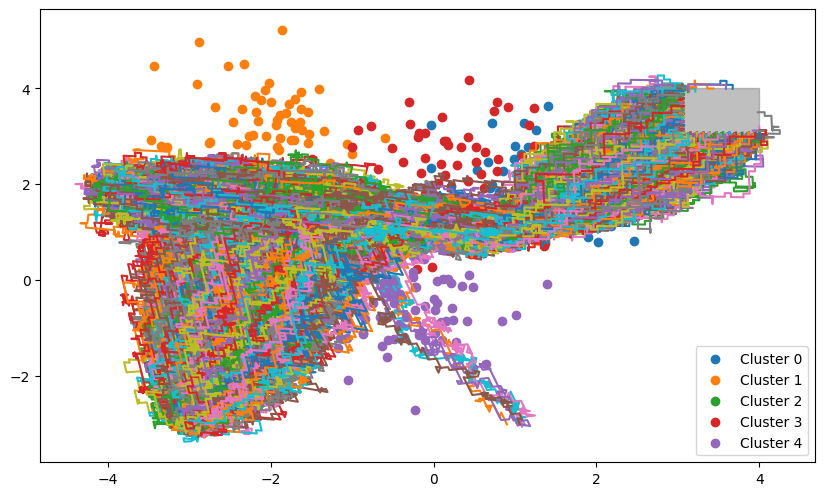

3680


In [116]:
def plot_trajectories(trajectories, means, clusters):
    fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
    for history in trajectories:
        plt.plot(history[:, 0], history[:, 1])

    rect = patches.Rectangle([3, 3], 1, 1, fill=True, color="grey", alpha=0.5)
    ax.add_patch(rect)
    for i in range(len(means)):
        points_in_clusters = int(len(clusters) / len(means))
        start = i * points_in_clusters
        end = (i + 1) * points_in_clusters
        plt.scatter(
            clusters[start:end, 0], clusters[start:end, 1], label=f"Cluster {i}"
        )

    plt.legend()
    plt.show()


trajectory_subset = trajectories[
    list(
        set(
            concepts_to_trajectories_mapping[(0, 2, 3, 4)]
            + concepts_to_trajectories_mapping[(0, 1, 2, 3, 4)]
            + concepts_to_trajectories_mapping[(0, 2, 3)]
            + concepts_to_trajectories_mapping[(0, 1, 2, 3)]
            + concepts_to_trajectories_mapping[(0, 1, 3, 4)]
          
        )
    )
]
plot_trajectories(trajectory_subset, means, clusters)
print(len(trajectory_subset))

In [117]:

def pre_process(trajectories_original, actions_original, concept_model=None, pi_b=None,  pi_b_c=None, concept_mapping=None, concept_path=None):
    behaviour_distributions = []
    evaluation_distributions = []
    action_indicies = []
    trajectories = copy.deepcopy(trajectories_original)
    actions = copy.deepcopy(actions_original)

    subset_indicies = []
    if concept_mapping:
        for path in concept_path:
            subset_indicies += concept_mapping[path]
        subset_indicies = list(set(subset_indicies))
        trajectories = trajectories[subset_indicies] #selects subset of trajectories which travelled through a certain path of concepts
        actions = actions[subset_indicies]
        

    print("Pre-processing data....")
    for idx in tqdm(range(len(trajectories))):
        completed_actions = actions[idx]
        trajectory = trajectories[idx]
        action_indicies.append(actions_to_action_indexes(completed_actions))

        if concept_model is not None:
            concepts = predict_concepts_from_states(trajectory, concept_model)
            behaviour_distributions.append(predict_actions_from_concepts(concepts, pi_b_c))
        else:
            behaviour_distributions.append(predict_actions_from_states(trajectory, pi_b))
    
    evaluation_distributions = copy.deepcopy(behaviour_distributions)
    print("Finished.")
    return behaviour_distributions, evaluation_distributions, action_indicies, trajectories, subset_indicies


def actions_to_action_indexes(actions):
    up = [0, 1]
    down = [0, -1]
    right = [1, 0]
    left = [-1, 0]
    A = np.array([up, down, right, left]) #action space
    '''Returns the index of the action in the state space, e.g. 0 for up, 1 for right etc'''
    return np.array([np.where(np.all((A == a), axis=1))[0][0] for a in actions])

def predict_concepts_from_states(trajectory, concept_model):
    return np.array(concept_model.predict(trajectory))

def predict_actions_from_states(trajectory, pi_b):
    return np.array(pi_b.predict(trajectory)) 
    # self.evaluation_distributions = np.copy(self.behaviour_distributions)

def predict_actions_from_concepts(concepts, pi_b_c):
    # concepts = [np.where(c == np.max(c),1,0).tolist() for c in concepts] #create one hot encoding
    return np.array(pi_b_c.predict(concepts))


class Estimator():

    up = [0, 1]
    down = [0, -1]
    right = [1, 0]
    left = [-1, 0]
    A = np.array([up, down, right, left]) #action space

    def __init__(self, trajectories_subset, behaviour_distributions, evaluation_distributions, action_indicies, *args, **kwargs):
        self.trajectories = trajectories_subset
        self.behaviour_distributions = copy.deepcopy(behaviour_distributions)
        self.evaluation_distributions = copy.deepcopy(evaluation_distributions)
        self.action_indicies = copy.deepcopy(action_indicies)
        self.args = args
        self.kwargs = kwargs

    def IS():
        pass

    def PDIS(self, D, eval_policy):   
        value_estimate = 0
        on_policy_value = 0
        total_likelihood_ratios=0
        non_unit_likelihood_ratios=0
        vanishing_products = 0
        observed_evaluation_distributions = []

        #sample D trajectories from the dataset
        indicies = np.random.choice(len(self.trajectories), D, replace=False)
    
        for t in indicies:
            behaviour_dist = self.behaviour_distributions[t]
            behaviour_trajectory = self.trajectories[t]
            evaluation_dist = self.evaluation_distributions[t]
            action_idxs = self.action_indicies[t]
            T = len(behaviour_dist) #trajectory length

            product, count, evaluation_distributions_copy =  self.rho(behaviour_trajectory, action_idxs, behaviour_dist, evaluation_dist, eval_policy)
            sum = self.g(T)
            value_estimate += sum  * product
            on_policy_value += sum
            non_unit_likelihood_ratios+= count
            total_likelihood_ratios += T
            observed_evaluation_distributions.append(evaluation_distributions_copy)
            if product < 0.3:
                vanishing_products+=1
            

        return value_estimate/D, (non_unit_likelihood_ratios/total_likelihood_ratios)*100, on_policy_value/D, observed_evaluation_distributions, vanishing_products

    def rho(self, behaviour_trajectory, actions_idx, behaviour_dist, evaluation_dist, eval_policy):
        product = 1
        count = 0

        r,_ = behaviour_dist.shape
        behaviour_probabilities = behaviour_dist[np.arange(r), actions_idx]
        evaluation_dist_copy = copy.deepcopy(evaluation_dist)
        # print(len(evaluation_dist), len(behaviour_dist), len(behaviour_trajectory))
        for j in range(len(evaluation_dist)):
            # epsilon = 0.2
            # dist_index = np.random.choice([0,1],1,p=[1-epsilon,epsilon])[0]
            # if dist_index == 1:
            #     replacement_distribution = [0.25, 0.25, 0.25, 0.25] 
            #     evaluation_dist_copy[j] = replacement_distribution
            
            if behaviour_trajectory[j][0] < -1 and behaviour_trajectory[j][1] < -1: #region based
                epsilon = 0.7
                dist_index = np.random.choice([0,1],1,p=[1-epsilon,epsilon])[0]
                if dist_index == 1:
                    evaluation_dist_copy[j] = eval_policy 
                    
            
        
        r,_ = evaluation_dist_copy.shape
        evaluation_probabilities = evaluation_dist_copy[np.arange(r), actions_idx]
        ratios = np.array(evaluation_probabilities/behaviour_probabilities)
        product = np.prod(ratios)
        count = len(np.where(ratios<0.8)[0])
        
        return product, count, evaluation_dist_copy

    def g(self, T, gamma=1):
        r_t = -1
        return T*r_t

In [118]:
paths = [(0, 2, 3, 4), (0, 1, 2, 3, 4), (0, 2, 3), (0, 1, 2, 3), (0, 1, 3, 4)]
(
    behaviour_distributions,
    evaluation_distributions,
    action_indicies,
    trajectories_subset,
    subset_indicies,
) = pre_process(
    trajectories[0:3000],
    actions,
    None,
    pi_b,
    None,
    concept_mapping=None,
    concept_path=paths,
)
(
    behaviour_distributions_c,
    evaluation_distributions_c,
    action_indicies_c,
    trajectories_subset_c,
    subset_indicies,
) = pre_process(
    trajectories[0:3000],
    actions,
    concept_model,
    pi_b,
    pi_b_c,
    concept_mapping=None,
    concept_path=paths,
)

print("Dataset size: ", len(behaviour_distributions))

Pre-processing data....



Finished.
Pre-processing data....



Finished.
Dataset size:  3000


In [189]:
def reject_outliers(data, m = 4.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else np.zeros(len(d))
    # print(s)
    return data[s<m]

estimator = Estimator(trajectories_subset=trajectories_subset,behaviour_distributions=behaviour_distributions, evaluation_distributions=evaluation_distributions, action_indicies=action_indicies)
concept_estimator = Estimator(trajectories_subset=trajectories_subset, behaviour_distributions=behaviour_distributions_c, evaluation_distributions=evaluation_distributions_c, action_indicies=action_indicies)

dataset_sizes = [100, 300, 500, 700, 850]
dataset_sizes = [500, 1000, 2000]
num_trials = 20
data = {}
data_no_outliers = {}

for D in dataset_sizes:
    values1, values2, ess_values1, ess_values2, vanishing, vanishing_c = [], [], [], [], [], []
    for i in tqdm(range(num_trials)):  
        eval_policy = [0.43, 0.1, 0.37, 0.1]# [0.438365   0.11837474 0.3666041  0.07665614] is actual distribution over concept 2
        estimate, small_weights, on_policy_value, observed_evaluation_distributions, vanishing_products = estimator.PDIS(D, eval_policy=eval_policy)
        estimate_concepts, small_weights_concepts, on_policy_value_concepts, observed_evaluation_distributions_concepts, vanishing_products_c = concept_estimator.PDIS(D, eval_policy=eval_policy)
        values1.append(estimate)
        values2.append(estimate_concepts)
        ess_values1.append(small_weights)
        ess_values2.append(small_weights_concepts)
        vanishing.append(vanishing_products)
        vanishing_c.append(vanishing_products_c)
    values1 = np.array(values1)
    values2 = np.array(values2)
    data[f"{D}_vanilla"] = values1
    data[f"{D}_concepts"] = values2
    data_no_outliers[f"{D}_vanilla"] = reject_outliers(values1)
    data_no_outliers[f"{D}_concepts"] = reject_outliers(values2)
    print(f"Mean weights smaller than 0.8: {np.array(ess_values1).mean()}%")
    print(f"Mean weights smaller than 0.8 concepts: {np.array(ess_values2).mean()}%")
    print(f"Mean vanishing products: {np.array(vanishing).mean()}")
    print(f"Mean vanishing products concepts: {np.array(vanishing_c).mean()}")
    print("On policy: ", on_policy_value)
    print("On policy over concepts: ", on_policy_value_concepts)



Mean weights smaller than 0.8: 2.4821959316519675%
Mean weights smaller than 0.8 concepts: 0.017255315642683306%
Mean vanishing products: 95.95
Mean vanishing products concepts: 4.4
On policy:  -345.44
On policy over concepts:  -338.208



Mean weights smaller than 0.8: 2.5414314316908806%
Mean weights smaller than 0.8 concepts: 0.013469741289883336%
Mean vanishing products: 198.65
Mean vanishing products concepts: 9.4
On policy:  -341.07
On policy over concepts:  -339.74



Mean weights smaller than 0.8: 2.5259822797958065%
Mean weights smaller than 0.8 concepts: 0.015450007907853908%
Mean vanishing products: 392.6
Mean vanishing products concepts: 18.1
On policy:  -339.838
On policy over concepts:  -339.982


In [ ]:
index = 1
for i in range(50,100):
    print(observed_evaluation_distributions_concepts[index][i], behaviour_distributions_c[index][i])

In [190]:
# data = {"vanilla":values1,"concepts":values2, "vanilla_no_outliers":reject_outliers(values1),"concepts_no_outliers":reject_outliers(values2)}
df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in data.items() ]))
df_no_outliers = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in data_no_outliers.items()]))

print("With outliers")
print(df.describe())
print("Without outliers")
print(df_no_outliers.describe())

With outliers
       500_vanilla  500_concepts  1000_vanilla  1000_concepts  2000_vanilla  \
count    20.000000     20.000000     20.000000      20.000000     20.000000   
mean   -335.343744   -366.580709   -348.629774    -362.137386   -346.898659   
std      44.991031     14.234799     56.069382       7.473841     34.148028   
min    -467.551053   -414.743502   -465.580131    -376.693430   -456.045987   
25%    -345.066931   -373.571215   -381.671770    -369.083432   -357.620314   
50%    -328.443471   -364.153064   -328.098771    -361.745005   -343.492170   
75%    -307.594784   -358.679904   -307.264621    -357.754883   -324.724770   
max    -279.051440   -349.979745   -284.777340    -349.593472   -308.535347   

       2000_concepts  
count      20.000000  
mean     -362.733420  
std         5.059323  
min      -373.118419  
25%      -364.681762  
50%      -363.065553  
75%      -359.557215  
max      -351.966326  
Without outliers
       500_vanilla  500_concepts  1000_vanilla  10

- Can we confidently say a bad policy is bad?
- Can we confidently say a good policy is good?
- Can we identify good sets of concepts and bad sets of concepts?

The above is key to figure out what types of concepts lead to a) better returns but more importantly which types of concepts lead to b) better bias variance guarantees

In some previous experimentation, I couldn't really say what policy was good or not since they started from different initial states, and I was only
looking at trajectories starting in one of the three states. What I was doing is completely valid, but the results were not clearly comparable to the on policy value, 
making it difficult to tell if a policy is actually good or not.

In [282]:


# df.to_parquet("parquets/10_concepts_experiments/ope_estimates_good_policy")
# df_no_outliers.to_parquet("parquets/10_concepts_experiments/ope_estimates_good_policy_no_outliers")

In [177]:
num_concepts = len(means)
eval_env = WindyGridworld(
    num_concepts=num_concepts,
    method="simple",
    knn=knn,
    means=means,
    policy_model=pi_b,
    concept_model=None,
    epsilon=0.3,
    eval_epsilon=0.7,
    eval_distribution= [0.44, 0.13, 0.33, 0.1], 
)

eval_trajectories = []
eval_rewards = []
eval_unique_concepts = []
eval_concepts = []
eval_actions = []


# Create evaluation trajectories in windy gridworld
for j in tqdm(range(30)):
    starting_positions = [np.array([-3, -3]), np.array([-4, 2]), np.array([1, -3])]
    s = starting_positions[np.random.choice([0,1],1)[0]]
    eval_env.play(
        True,
        eval_trajectories,
        eval_rewards,
        eval_unique_concepts,
        eval_concepts,
        eval_actions,
        s=s,
        use_eval_policy=True,
    )

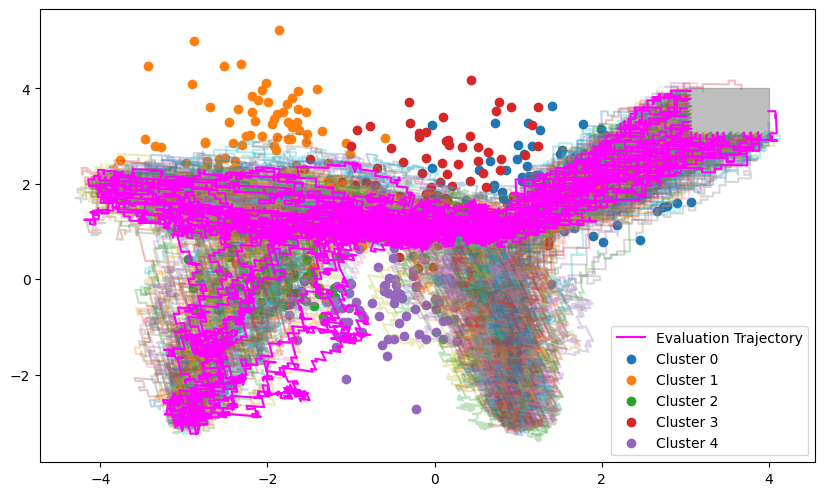

In [178]:
def plot_eval_trajectories(eval_trajectories,trajectories):
    fig, ax = plt.subplots(figsize=(10,6), dpi=100)
    
    
    for history in trajectories:
        plt.plot(history[:, 0], history[:, 1], alpha=0.3)

    for history in eval_trajectories:
        plt.plot(history[:, 0], history[:, 1], color="magenta")
    plt.plot(history[0, 0], history[0, 1], color="magenta", label="Evaluation Trajectory") #for legend purposes

    rect = patches.Rectangle([3, 3], 1, 1, fill=True, color="grey", alpha=0.5)
    ax.add_patch(rect)
    for i in range(len(means)):
        num_points = int(len(clusters)/len(means))
        start = i*num_points
        end = (i+1)*num_points
        plt.scatter(clusters[start:end,0], clusters[start:end,1], label=f"Cluster {i}")

    plt.legend(loc="lower right")
    plt.show()

plot_eval_trajectories(eval_trajectories, trajectories_subset[np.random.choice(len(trajectories_subset), 500, replace=False)])

In [179]:
lengths = [len(eval_traj) for eval_traj in eval_trajectories]
print(lengths)
print(np.array(lengths).mean())

[491, 566, 478, 396, 443, 464, 277, 332, 343, 320, 270, 321, 487, 484, 458, 529, 512, 326, 453, 312, 326, 310, 299, 366]
398.4583333333333
